In [4]:
import wandb
from wandb.keras import WandbCallback

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import MaxPooling2D, Input, concatenate, Conv2D, Activation, ZeroPadding2D, UpSampling2D, add
from tensorflow.keras.models import *
from qkeras import *

import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import load_img

import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.utils import shuffle
from tqdm import tqdm

In [5]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Num GPUs: 2


In [6]:
#TODO: Data generation
PRETRAINED = True
BASE_PATH = "/nfs_scratch/hsharma/MachineLearning/ClusterFinder/data/images/"
IMG_PATH = 'input/'
ANNOTATION_PATH = 'trimaps/'
num = 10000

input_img_paths = sorted(
    [
        os.path.join(BASE_PATH, IMG_PATH, fname)
        for fname in os.listdir(BASE_PATH+IMG_PATH)
        if fname.endswith(".png") and "(" not in fname
    ]
)[:num]


annotation_img_paths = []

for fname in tqdm(input_img_paths[:num]):
    annp = os.path.join(BASE_PATH, ANNOTATION_PATH, fname.split("/")[-1].replace("img", "annm"))
    if os.path.isfile(annp):
        annotation_img_paths.append(annp)
        input_img_paths.append(fname)
    else:
        pass

input_img_paths = input_img_paths[num:]
len(input_img_paths), len(annotation_img_paths)

100%|██████████| 10000/10000 [00:01<00:00, 6601.38it/s]


(10000, 10000)

In [7]:
[x for x in input_img_paths if "(" in x]

[]

In [8]:
input_img_paths[0], annotation_img_paths[0]

('/nfs_scratch/hsharma/MachineLearning/ClusterFinder/data/images/input/ECAL_img_0.png',
 '/nfs_scratch/hsharma/MachineLearning/ClusterFinder/data/images/trimaps/ECAL_annm_0.png')

[1103 2782 6071 5770]


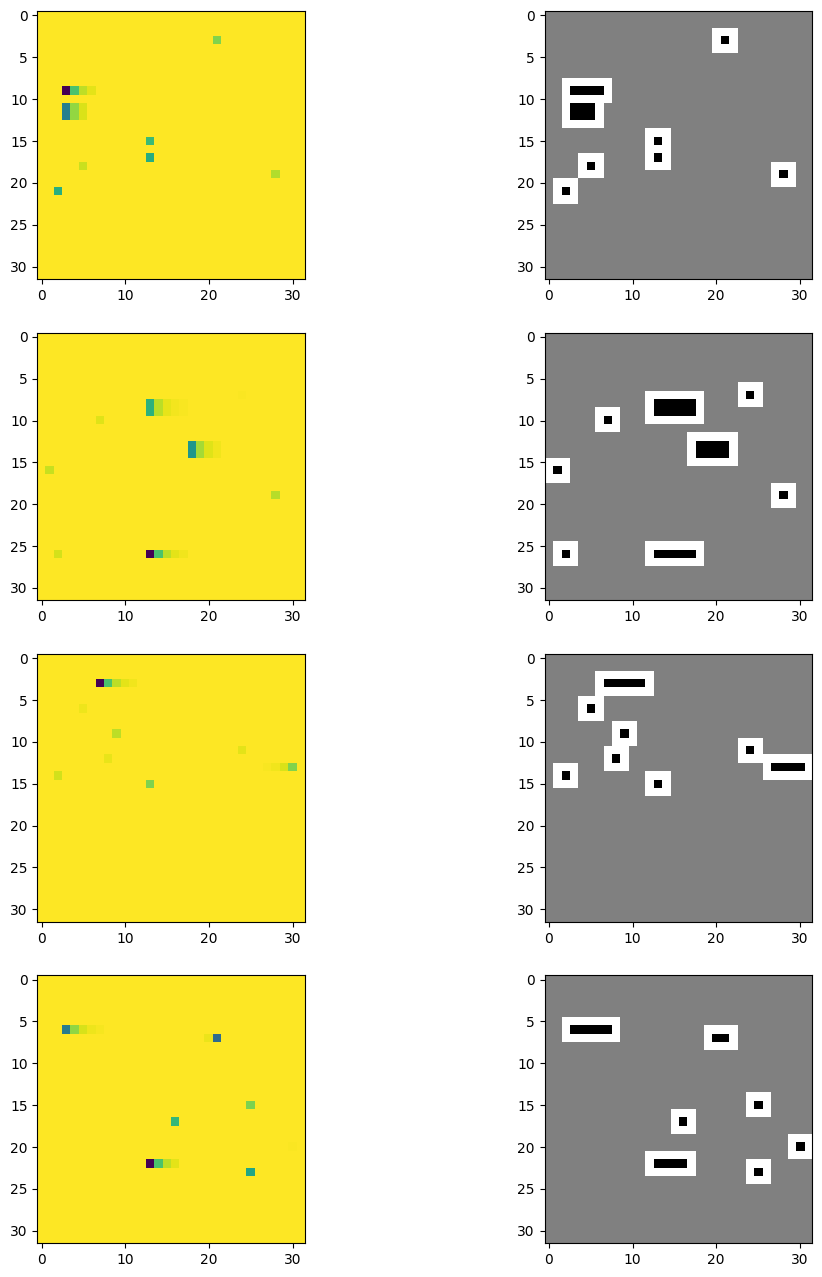

In [9]:
num_example_to_display = 4

sample_idxs = np.random.randint(0, len(input_img_paths)-1, size=(num_example_to_display,))
#sample_idxs = [0, 1, 2, 3]
print(sample_idxs)

fig, axs = plt.subplots(nrows=num_example_to_display, ncols=2, figsize=(12,4*num_example_to_display))

for i, sample_idx in enumerate(sample_idxs):
  img = Image.open(input_img_paths[sample_idx]) 
  mask = Image.open(annotation_img_paths[sample_idx])
  #img = Image.fromarray(np.array(img))
  axs[i][0].imshow(img)
  axs[i][1].imshow(mask, cmap='gray')

In [10]:
np.unique(mask)

array([1, 2, 3], dtype=uint8)

In [11]:
IMG_SHAPE = 32

def normalize(image, mask):
    image = tf.cast(image, tf.float32) / 255.0
    mask -= 1
    return image, mask

def load_and_preprocess(img_filepath, mask_filepath):
    img = tf.io.read_file(img_filepath)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SHAPE, IMG_SHAPE])

    mask = tf.io.read_file(mask_filepath)
    mask = tf.io.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, [IMG_SHAPE, IMG_SHAPE])

    img, mask = normalize(img, mask)

    return img, mask

In [12]:
AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32

input_img_paths, annotation_img_paths = shuffle(input_img_paths, annotation_img_paths, random_state=42)
input_img_paths_train, annotation_img_paths_train = input_img_paths[: -1200], annotation_img_paths[: -1200]
input_img_paths_test, annotation_img_paths_test = input_img_paths[-1200:-800], annotation_img_paths[-1200:-800]

trainloader = tf.data.Dataset.from_tensor_slices((input_img_paths_train, annotation_img_paths_train))
testloader = tf.data.Dataset.from_tensor_slices((input_img_paths_test, annotation_img_paths_test))

trainloader = (
    trainloader
    .shuffle(1024)
    .map(load_and_preprocess, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

testloader = (
    testloader
    .map(load_and_preprocess, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

2023-02-26 17:40:45.131835: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-26 17:40:45.500696: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-26 17:40:45.502176: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-26 17:40:45.503498: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

In [13]:
input_img_paths_test, annotation_img_paths_test = input_img_paths[-800:], annotation_img_paths[-800:]
maintestloader = tf.data.Dataset.from_tensor_slices((input_img_paths_test, annotation_img_paths_test))

maintestloader = (
    maintestloader
    .map(load_and_preprocess, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

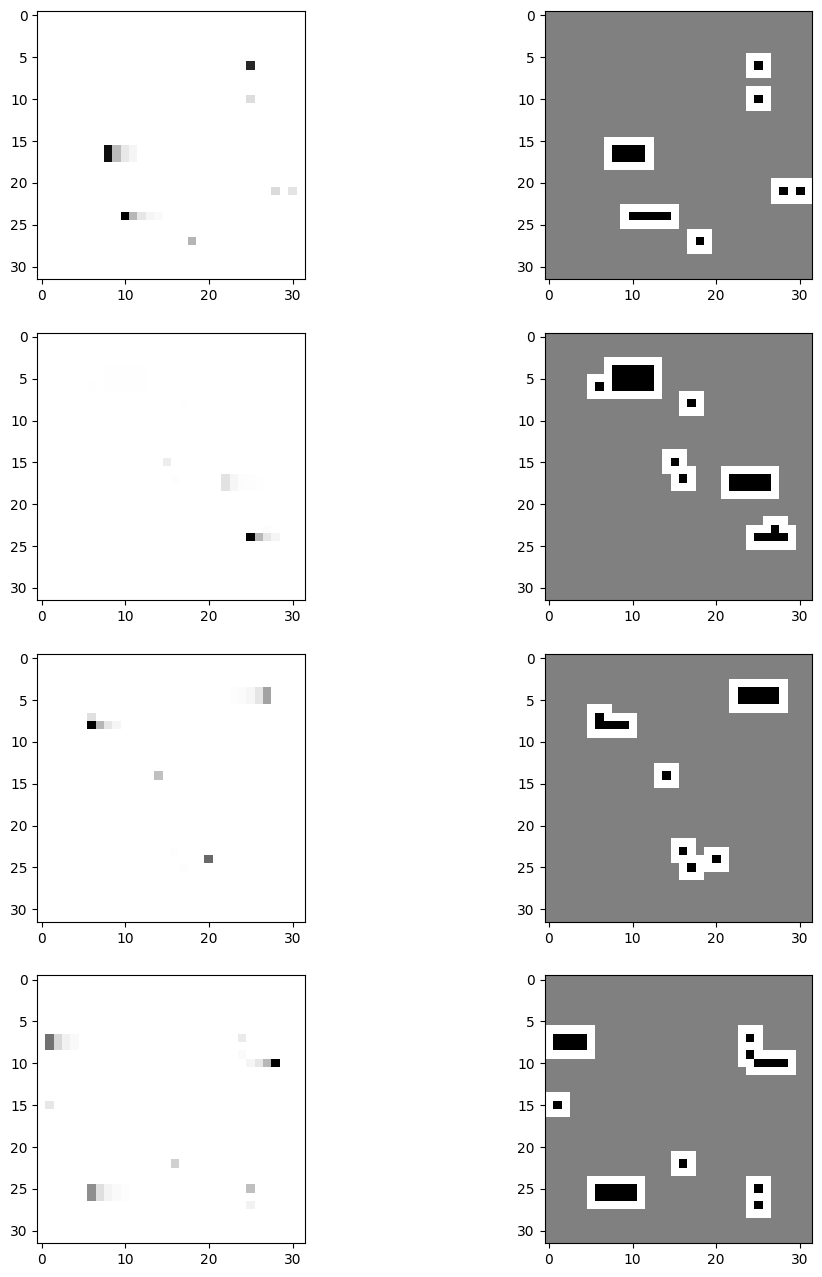

In [14]:
num_example_to_display = 4

img, mask = next(iter(trainloader))

fig, axs = plt.subplots(nrows=num_example_to_display, ncols=2, figsize=(12,4*num_example_to_display))

for i in range(num_example_to_display):
  axs[i][0].imshow(img[i]);
  axs[i][1].imshow(np.squeeze(mask[i],-1), cmap='gray');

In [15]:
np.unique(mask)

array([0., 1., 2.], dtype=float32)

In [16]:
# ref: https://github.com/ayulockin/deepimageinpainting/blob/master/Image_Inpainting_Autoencoder_Decoder_v2_0.ipynb
class SegmentationModel:
    '''
    Build UNET based model for segmentation task.
    '''
    def prepare_model(self, OUTPUT_CHANNEL, input_size=(IMG_SHAPE,IMG_SHAPE,3)):
        inputs = Input(input_size)

        conv1, pool1 = self.__ConvBlock(32, (3,3), (2,2), 'relu', 'same', inputs) 
        conv2, pool2 = self.__ConvBlock(64, (3,3), (2,2), 'relu', 'same', pool1)
        conv3, pool3 = self.__ConvBlock(128, (3,3), (2,2), 'relu', 'same', pool2) 
        conv4, pool4 = self.__ConvBlock(256, (3,3), (2,2), 'relu', 'same', pool3) 

        conv5, up6 = self.__UpConvBlock(512, 256, (3,3), (2,2), (2,2), 'relu', 'same', pool4, conv4)
        conv6, up7 = self.__UpConvBlock(256, 128, (3,3), (2,2), (2,2), 'relu', 'same', up6, conv3)
        conv7, up8 = self.__UpConvBlock(128, 64, (3,3), (2,2), (2,2), 'relu', 'same', up7, conv2)
        conv8, up9 = self.__UpConvBlock(64, 32, (3,3), (2,2), (2,2), 'relu', 'same', up8, conv1)

        conv9 = self.__ConvBlock(32, (3,3), (2,2), 'relu', 'same', up9, False)

        outputs = Conv2D(OUTPUT_CHANNEL, (3, 3), activation='softmax', padding='same')(conv9)

        return Model(inputs=[inputs], outputs=[outputs])  

    def __ConvBlock(self, filters, kernel_size, pool_size, activation, padding, connecting_layer, pool_layer=True):
        conv = Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
        conv = Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
        if pool_layer:
            pool = MaxPooling2D(pool_size)(conv)
            return conv, pool
        else:
            return conv

    def __UpConvBlock(self, filters, up_filters, kernel_size, up_kernel, up_stride, activation, padding, connecting_layer, shared_layer):
        conv = Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
        conv = Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
        up = Conv2DTranspose(filters=up_filters, kernel_size=up_kernel, strides=up_stride, padding=padding)(conv)
        up = concatenate([up, shared_layer], axis=3)

        return conv, up

In [21]:
class UNETLiteModel:
    '''
    Build UNET based model for segmentation task.
    '''
    def prepare_model(self, OUTPUT_CHANNEL, input_size=(IMG_SHAPE,IMG_SHAPE,3)):
        inputs = Input(input_size)

        conv1, pool1 = self.__ConvBlock(8, (3,3), (2,2), 'relu', 'same', inputs) 
        conv2, pool2 = self.__ConvBlock(16, (3,3), (2,2), 'relu', 'same', pool1)
        conv3, pool3 = self.__ConvBlock(32, (3,3), (2,2), 'relu', 'same', pool2) 

        conv5, up6 = self.__UpConvBlock(64, 32, (3,3), (2,2), (2,2), 'relu', 'same', pool3, conv3)
        conv6, up7 = self.__UpConvBlock(32, 16, (3,3), (2,2), (2,2), 'relu', 'same', up6, conv2)
        conv7, up8 = self.__UpConvBlock(16, 8, (3,3), (2,2), (2,2), 'relu', 'same', up7, conv1)

        conv8 = self.__ConvBlock(8, (3,3), (2,2), 'relu', 'same', up8, False)

        outputs = Conv2D(OUTPUT_CHANNEL, (3, 3), activation='softmax', padding='same')(conv8)

        return Model(inputs=[inputs], outputs=[outputs])  

    def __ConvBlock(self, filters, kernel_size, pool_size, activation, padding, connecting_layer, pool_layer=True):
        conv = Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
        conv = Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
        if pool_layer:
            pool = MaxPooling2D(pool_size)(conv)
            return conv, pool
        else:
            return conv

    def __UpConvBlock(self, filters, up_filters, kernel_size, up_kernel, up_stride, activation, padding, connecting_layer, shared_layer):
        conv = Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
        conv = Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
        up = Conv2DTranspose(filters=up_filters, kernel_size=up_kernel, strides=up_stride, padding=padding)(conv)
        up = concatenate([up, shared_layer], axis=3)

        return conv, up

In [35]:
IMG_SHAPE = 32

class EnetModel:
    '''
    Build ENET based model for segmentation task.
    Built for FPGA 240x152 implementation
    '''
  
    def prepare_model(self, OUTPUT_CHANNEL, input_size=(IMG_SHAPE,IMG_SHAPE,3)):
        # 8x Resolution Model
        fi, f1, f2, f3, f4, f5 = 32, 64, 64, 64, 128, 48

        # 240 x 152
        inputs = Input(input_size)

        initial = self.__InitialBlock(29, (3, 3), (2,2), inputs)
        encode1 = self.__EncoderBlock(fi, f1, initial)
        encode2 = self.__EncoderBlock(f1, f2, encode1)

        # 30 x 19 
        encode3 = Conv2D(filters=f3, kernel_size=(1, 1))(encode2)
        encode3 = BatchNormalization()(encode3)

        decode2 = self.__DecoderBlock(f3, f4, encode3)
        decode1 = self.__DecoderBlock(f4, f5, decode2)

        # 240 x 152
        outputs = self.__FinalBlock(OUTPUT_CHANNEL, decode1)

        return Model(inputs=[inputs], outputs=[outputs])  

    def __InitialBlock(self, filters, kernel_size, pool_size, connecting_layer):
        pool_stride = (2, 2)
        pool = MaxPooling2D(pool_size, strides=pool_stride)(connecting_layer)

        # NOTE: unlike paper we do symmetrical padding (1 around)
        padded_pool = ZeroPadding2D(padding=((0, 2), (0, 2)))(pool)
        conv_i = Conv2D(filters=filters, kernel_size=kernel_size)(padded_pool)
        conv_i = BatchNormalization()(conv_i)

        # 3 layers + 29 layers from filters
        concat = concatenate([pool, conv_i], axis=-1)
        out = Activation("relu")(concat)

        return out
  
    def __FinalBlock(self, channels, connecting_layer):
        up_f = UpSampling2D(size=(2, 2))(connecting_layer)
        pad_f = ZeroPadding2D(padding=((0, 1), (0, 1)))(up_f)

        out = Conv2D(filters = channels, kernel_size=(2, 2), activation="softmax")(pad_f)
        return out

    def __EncoderBlock(self, filters_i, filters_o, connecting_layer):
        pool_size, pool_stride = (2, 2), (2, 2)
        pool_1 = MaxPooling2D(pool_size, strides=pool_stride)(connecting_layer)

        # main branch
        padded_pool_1 = ZeroPadding2D(padding=((0, 1), (0, 1)))(pool_1)
        conv_1 = Conv2D(filters=filters_i, kernel_size=(2,2))(padded_pool_1)
        conv_1 = BatchNormalization()(conv_1)

        x_1 = Activation("relu")(conv_1)

        padded_pool_2 = ZeroPadding2D(padding=((0, 2), (0, 2)))(x_1)
        conv_2 = Conv2D(filters=filters_i, kernel_size=(3,3))(padded_pool_2)
        conv_2 = BatchNormalization()(conv_2)

        x_2 = Activation("relu")(conv_2)

        conv_3 = Conv2D(filters=filters_o, kernel_size=(1,1))(x_2)
        conv_3 = BatchNormalization()(conv_3)

        # skip branch
        conv_4 = Conv2D(filters=filters_o, kernel_size=(1,1))(pool_1)
        conv_4 = BatchNormalization()(conv_4)

        # add
        merged_layer = add([conv_3, conv_4])
        out = Activation("relu")(merged_layer)

        return out

    def __DecoderBlock(self, filters_i, filters_o, connecting_layer):

        # skip branch
        conv_1 = Conv2D(filters=filters_o, kernel_size=(1,1))(connecting_layer)
        conv_1 = BatchNormalization()(conv_1)
        up_1 = UpSampling2D(size=(2, 2))(conv_1)

        # main_branch
        padded_pool_1 = ZeroPadding2D(padding=((0, 1), (0, 1)))(connecting_layer) # missing from paper
        conv_2 = Conv2D(filters=filters_i, kernel_size=(2,2))(padded_pool_1)
        conv_2 = BatchNormalization()(conv_2)

        x_2 = Activation("relu")(conv_2)

        up_2 = UpSampling2D(size=(2, 2))(x_2)
        padded_pool_2 = ZeroPadding2D(padding=((0, 2), (0, 2)))(up_2)

        conv_3 = Conv2D(filters=filters_i, kernel_size=(3,3))(padded_pool_2)
        conv_3 = BatchNormalization()(conv_3)

        x_3 = Activation("relu")(conv_3)

        conv_4 = Conv2D(filters=filters_o, kernel_size=(1, 1))(x_3)
        conv_4 = BatchNormalization()(conv_4)

        # Add and ReLU
        merged_layer = add([up_1, conv_4])
        out = Activation("relu")(merged_layer)

        return out

In [36]:
IMG_SHAPE = 32

class QEnetModel:
    '''
      Build ENET based model for segmentation task.
      Built for FPGA 240x152 implementation
    '''
    def prepare_model(self, OUTPUT_CHANNEL, input_size=(IMG_SHAPE,IMG_SHAPE,3)):
        # 8x Resolution Model
        fi, f1, f2, f3, f4, f5 = 32, 64, 64, 64, 128, 48

        # 240 x 152
        inputs = Input(input_size)

        initial = self.__InitialBlock(29, (3, 3), (2,2), inputs)
        encode1 = self.__EncoderBlock(fi, f1, initial)
        encode2 = self.__EncoderBlock(f1, f2, encode1)

        # 30 x 19 
        encode3 = QConv2DBatchnorm(filters=f3, kernel_size=(1, 1))(encode2)

        decode2 = self.__DecoderBlock(f3, f4, encode3)
        decode1 = self.__DecoderBlock(f4, f5, decode2)

        # 240 x 152
        outputs = self.__FinalBlock(OUTPUT_CHANNEL, decode1)

        return Model(inputs=[inputs], outputs=[outputs])  

    def __InitialBlock(self, filters, kernel_size, pool_size, connecting_layer):
        pool_stride = (2, 2)
        pool = MaxPooling2D(pool_size, strides=pool_stride)(connecting_layer)

        # NOTE: unlike paper we do symmetrical padding (1 around)
        padded_pool = ZeroPadding2D(padding=((0, 2), (0, 2)))(pool)
        conv_i = QConv2DBatchnorm(filters=filters, kernel_size=kernel_size)(padded_pool)

        # 3 layers + 29 layers from filters
        concat = concatenate([pool, conv_i], axis=-1)
        out = Activation("relu")(concat)

        return out
  
    def __FinalBlock(self, channels, connecting_layer):
        up_f = UpSampling2D(size=(2, 2))(connecting_layer)
        pad_f = ZeroPadding2D(padding=((0, 1), (0, 1)))(up_f)

        out = QConv2D(filters = channels, kernel_size=(2, 2), activation="softmax")(pad_f)
        return out

    def __EncoderBlock(self, filters_i, filters_o, connecting_layer):
        pool_size, pool_stride = (2, 2), (2, 2)
        pool_1 = MaxPooling2D(pool_size, strides=pool_stride)(connecting_layer)

        # main branch
        padded_pool_1 = ZeroPadding2D(padding=((0, 1), (0, 1)))(pool_1)
        conv_1 = QConv2DBatchnorm(filters=filters_i, kernel_size=(2,2))(padded_pool_1)
        x_1 = Activation("relu")(conv_1)

        padded_pool_2 = ZeroPadding2D(padding=((0, 2), (0, 2)))(x_1)
        conv_2 = QConv2DBatchnorm(filters=filters_i, kernel_size=(3,3))(padded_pool_2)
        x_2 = Activation("relu")(conv_2)

        conv_3 = QConv2DBatchnorm(filters=filters_o, kernel_size=(1,1))(x_2)

        # skip branch
        conv_4 = QConv2DBatchnorm(filters=filters_o, kernel_size=(1,1))(pool_1)

        # add
        merged_layer = add([conv_3, conv_4])
        out = Activation("relu")(merged_layer)

        return out

    def __DecoderBlock(self, filters_i, filters_o, connecting_layer):

        # skip branch
        conv_1 = QConv2DBatchnorm(filters=filters_o, kernel_size=(1,1))(connecting_layer)
        up_1 = UpSampling2D(size=(2, 2))(conv_1)

        # main_branch
        padded_pool_1 = ZeroPadding2D(padding=((0, 1), (0, 1)))(connecting_layer) # missing from paper
        conv_2 = QConv2DBatchnorm(filters=filters_i, kernel_size=(2,2))(padded_pool_1)
        x_2 = Activation("relu")(conv_2)

        up_2 = UpSampling2D(size=(2, 2))(x_2)
        padded_pool_2 = ZeroPadding2D(padding=((0, 2), (0, 2)))(up_2)

        conv_3 = QConv2DBatchnorm(filters=filters_i, kernel_size=(3,3))(padded_pool_2)
        x_3 = Activation("relu")(conv_3)

        conv_4 = QConv2DBatchnorm(filters=filters_o, kernel_size=(1, 1))(x_3)

        # Add and ReLU
        merged_layer = add([up_1, conv_4])
        out = Activation("relu")(merged_layer)

        return out

In [38]:
# output channel is 3 because we have three classes in our mask
OUTPUT_CHANNEL = 3

tf.keras.backend.clear_session()
model = EnetModel().prepare_model(OUTPUT_CHANNEL, input_size=(32, 32, 3))
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy")

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 16, 16, 3)    0           ['input_1[0][0]']                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 18, 18, 3)   0           ['max_pooling2d[0][0]']          
                                                                                                  
 conv2d (Conv2D)                (None, 16, 16, 29)   812         ['zero_padding2d[0][0]']         
                                                                                              

 rmalization)                                                                                     
                                                                                                  
 batch_normalization_8 (BatchNo  (None, 4, 4, 64)    256         ['conv2d_8[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 add_1 (Add)                    (None, 4, 4, 64)     0           ['batch_normalization_7[0][0]',  
                                                                  'batch_normalization_8[0][0]']  
                                                                                                  
 activation_6 (Activation)      (None, 4, 4, 64)     0           ['add_1[0][0]']                  
                                                                                                  
 conv2d_9 

 up_sampling2d_2 (UpSampling2D)  (None, 16, 16, 48)  0           ['batch_normalization_14[0][0]'] 
                                                                                                  
 batch_normalization_17 (BatchN  (None, 16, 16, 48)  192         ['conv2d_17[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 add_3 (Add)                    (None, 16, 16, 48)   0           ['up_sampling2d_2[0][0]',        
                                                                  'batch_normalization_17[0][0]'] 
                                                                                                  
 activation_12 (Activation)     (None, 16, 16, 48)   0           ['add_3[0][0]']                  
                                                                                                  
 up_sampli

In [39]:
segmentation_classes = ['cluster', 'cluster_outline', 'background']

# returns a dictionary of labels
def labels():
    l = {}
    for i, label in enumerate(segmentation_classes):
        l[i] = label
    return l

# util function for generating interactive image mask from components
def wandb_mask(bg_img, pred_mask, true_mask):
    return wandb.Image(bg_img, masks={
      "prediction" : {
          "mask_data" : pred_mask, 
          "class_labels" : labels()
      },
      "ground truth" : {
          "mask_data" : true_mask, 
          "class_labels" : labels()
      }
    }
  )

In [40]:
class SemanticLogger(tf.keras.callbacks.Callback):
    def __init__(self):
        super(SemanticLogger, self).__init__()
        self.val_images, self.val_masks = next(iter(testloader))

    def on_epoch_end(self, logs, epoch):
        pred_masks = self.model.predict(self.val_images)
        pred_masks = np.argmax(pred_masks, axis=-1)

        val_images = tf.image.convert_image_dtype(self.val_images, tf.uint8)
        val_masks = tf.image.convert_image_dtype(self.val_masks, tf.uint8)
        val_masks = tf.squeeze(val_masks, axis=-1)
        
        pred_masks = tf.image.convert_image_dtype(pred_masks, tf.uint8)

        mask_list = []
        for i in range(len(self.val_images)):
            mask_list.append(wandb_mask(val_images[i].numpy(), 
                                      pred_masks[i].numpy(), 
                                      val_masks[i].numpy()))

        wandb.log({"predictions" : mask_list})

In [41]:
wandb.init(project='enet-cluster-segmentation', reinit=True)

_ = model.fit(trainloader, 
              epochs=50, 
              validation_data=testloader,
              callbacks=[WandbCallback(),
                         SemanticLogger()])

wandb.finish()

Epoch 1/50
275/275 [==============================] - ETA: 0s - loss: 0.3550

INFO:tensorflow:Assets written to: /nfs_scratch/hsharma/MachineLearning/ClusterFinder/notebooks/wandb/run-20230226_175518-8y9uyk1u/files/model-best/assets


INFO:tensorflow:Assets written to: /nfs_scratch/hsharma/MachineLearning/ClusterFinder/notebooks/wandb/run-20230226_175518-8y9uyk1u/files/model-best/assets
wandb: Adding directory to artifact (/nfs_scratch/hsharma/MachineLearning/ClusterFinder/notebooks/wandb/run-20230226_175518-8y9uyk1u/files/model-best)... Done. 0.4s


275/275 [==============================] - 23s 54ms/step - loss: 0.3550 - val_loss: 0.3965
Epoch 2/50
274/275 [============================>.] - ETA: 0s - loss: 0.3353

INFO:tensorflow:Assets written to: /nfs_scratch/hsharma/MachineLearning/ClusterFinder/notebooks/wandb/run-20230226_175518-8y9uyk1u/files/model-best/assets


INFO:tensorflow:Assets written to: /nfs_scratch/hsharma/MachineLearning/ClusterFinder/notebooks/wandb/run-20230226_175518-8y9uyk1u/files/model-best/assets
wandb: Adding directory to artifact (/nfs_scratch/hsharma/MachineLearning/ClusterFinder/notebooks/wandb/run-20230226_175518-8y9uyk1u/files/model-best)... Done. 0.5s


275/275 [==============================] - 14s 49ms/step - loss: 0.3353 - val_loss: 0.3823
Epoch 3/50
273/275 [============================>.] - ETA: 0s - loss: 0.3305

INFO:tensorflow:Assets written to: /nfs_scratch/hsharma/MachineLearning/ClusterFinder/notebooks/wandb/run-20230226_175518-8y9uyk1u/files/model-best/assets


INFO:tensorflow:Assets written to: /nfs_scratch/hsharma/MachineLearning/ClusterFinder/notebooks/wandb/run-20230226_175518-8y9uyk1u/files/model-best/assets
wandb: Adding directory to artifact (/nfs_scratch/hsharma/MachineLearning/ClusterFinder/notebooks/wandb/run-20230226_175518-8y9uyk1u/files/model-best)... Done. 0.5s


275/275 [==============================] - 14s 50ms/step - loss: 0.3305 - val_loss: 0.3641
Epoch 4/50
275/275 [==============================] - 7s 25ms/step - loss: 0.3272 - val_loss: 0.3714
Epoch 5/50
275/275 [==============================] - 7s 25ms/step - loss: 0.3202 - val_loss: 0.4032
Epoch 6/50
275/275 [==============================] - 7s 25ms/step - loss: 0.3151 - val_loss: 0.4523
Epoch 7/50
275/275 [==============================] - 7s 25ms/step - loss: 0.3116 - val_loss: 0.4416
Epoch 8/50
275/275 [==============================] - 7s 25ms/step - loss: 0.3091 - val_loss: 0.6815
Epoch 9/50
275/275 [==============================] - 7s 24ms/step - loss: 0.3096 - val_loss: 0.4398
Epoch 10/50
275/275 [==============================] - 7s 24ms/step - loss: 0.3077 - val_loss: 0.4924
Epoch 11/50
275/275 [==============================] - 7s 25ms/step - loss: 0.3061 - val_loss: 0.8066
Epoch 12/50
206/275 [=====================>........] - ETA: 1s - loss: 0.3057

wandb: Network error (TransientError), entering retry loop.


275/275 [==============================] - 7s 24ms/step - loss: 0.3052 - val_loss: 0.5808
Epoch 13/50
275/275 [==============================] - 7s 25ms/step - loss: 0.3042 - val_loss: 0.3815
Epoch 14/50
201/275 [====================>.........] - ETA: 1s - loss: 0.3040

wandb: Network error (TransientError), entering retry loop.


275/275 [==============================] - 7s 26ms/step - loss: 0.3037 - val_loss: 0.3830
Epoch 15/50
275/275 [==============================] - 7s 25ms/step - loss: 0.3034 - val_loss: 0.4552
Epoch 16/50
275/275 [==============================] - 7s 25ms/step - loss: 0.3048 - val_loss: 0.3810
Epoch 17/50
275/275 [==============================] - 7s 24ms/step - loss: 0.3050 - val_loss: 0.4714
Epoch 18/50
275/275 [==============================] - 7s 24ms/step - loss: 0.3034 - val_loss: 0.7131
Epoch 19/50
275/275 [==============================] - 7s 24ms/step - loss: 0.3027 - val_loss: 0.4837
Epoch 20/50
274/275 [============================>.] - ETA: 0s - loss: 0.3024

INFO:tensorflow:Assets written to: /nfs_scratch/hsharma/MachineLearning/ClusterFinder/notebooks/wandb/run-20230226_175518-8y9uyk1u/files/model-best/assets


INFO:tensorflow:Assets written to: /nfs_scratch/hsharma/MachineLearning/ClusterFinder/notebooks/wandb/run-20230226_175518-8y9uyk1u/files/model-best/assets
wandb: Adding directory to artifact (/nfs_scratch/hsharma/MachineLearning/ClusterFinder/notebooks/wandb/run-20230226_175518-8y9uyk1u/files/model-best)... Done. 0.5s


275/275 [==============================] - 14s 49ms/step - loss: 0.3025 - val_loss: 0.3546
Epoch 21/50
275/275 [==============================] - 7s 24ms/step - loss: 0.3018 - val_loss: 0.5892
Epoch 22/50
275/275 [==============================] - 7s 24ms/step - loss: 0.3013 - val_loss: 0.6209
Epoch 23/50
275/275 [==============================] - 7s 25ms/step - loss: 0.3011 - val_loss: 0.5342
Epoch 24/50
275/275 [==============================] - 7s 24ms/step - loss: 0.3009 - val_loss: 0.3778
Epoch 25/50
275/275 [==============================] - 7s 26ms/step - loss: 0.3006 - val_loss: 0.7162
Epoch 26/50
275/275 [==============================] - 7s 25ms/step - loss: 0.3004 - val_loss: 0.3614
Epoch 27/50
275/275 [==============================] - 7s 24ms/step - loss: 0.3001 - val_loss: 0.6139
Epoch 28/50
275/275 [==============================] - 7s 24ms/step - loss: 0.2997 - val_loss: 0.6662
Epoch 29/50
275/275 [==============================] - 7s 25ms/step - loss: 0.3002 - val_loss

wandb: Network error (TransientError), entering retry loop.


275/275 [==============================] - 7s 26ms/step - loss: 0.2960 - val_loss: 0.5849
Epoch 43/50
275/275 [==============================] - 7s 24ms/step - loss: 0.2957 - val_loss: 0.7546
Epoch 44/50
275/275 [==============================] - 7s 24ms/step - loss: 0.2954 - val_loss: 2.7747
Epoch 45/50
275/275 [==============================] - 7s 24ms/step - loss: 0.2950 - val_loss: 0.7501
Epoch 46/50
275/275 [==============================] - 7s 25ms/step - loss: 0.2947 - val_loss: 0.4103
Epoch 47/50
275/275 [==============================] - 7s 24ms/step - loss: 0.2946 - val_loss: 0.4849
Epoch 48/50
275/275 [==============================] - 7s 24ms/step - loss: 0.2939 - val_loss: 1.0118
Epoch 49/50
275/275 [==============================] - 7s 25ms/step - loss: 0.2937 - val_loss: 1.5676
Epoch 50/50
275/275 [==============================] - 7s 25ms/step - loss: 0.2933 - val_loss: 0.4713


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▆▅▅▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_loss,▁▁▁▁▁▁▂▁▂▂▁▁▁▁▂▁▂▂▂▁▁▂▂▁▂▆▄▁▁▄▃▄▄▂▂█▁▁▃▁
best_epoch,19
best_val_loss,0.3546
epoch,49
loss,0.29328
val_loss,0.47128


### Prediction

In [34]:
from keras.models import load_model

if PRETRAINED == True:
    MODEL_PATH = "/nfs_scratch/hsharma/MachineLearning/ClusterFinder/notebooks/wandb/run-20230226_175518-8y9uyk1u/files/model-best.h5"
    model = load_model(MODEL_PATH)

ValueError: Unknown layer: 'QConv2DBatchnorm'. Please ensure you are using a `keras.utils.custom_object_scope` and that this object is included in the scope. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.

In [26]:
val_img, val_mask = next(iter(testloader))

In [27]:
pred_mask = model.predict(val_img)
pred_mask = np.argmax(pred_mask, axis=-1)
pred_mask = np.expand_dims(pred_mask, axis=-1)

1/1 [==============================] - 0s 378ms/step


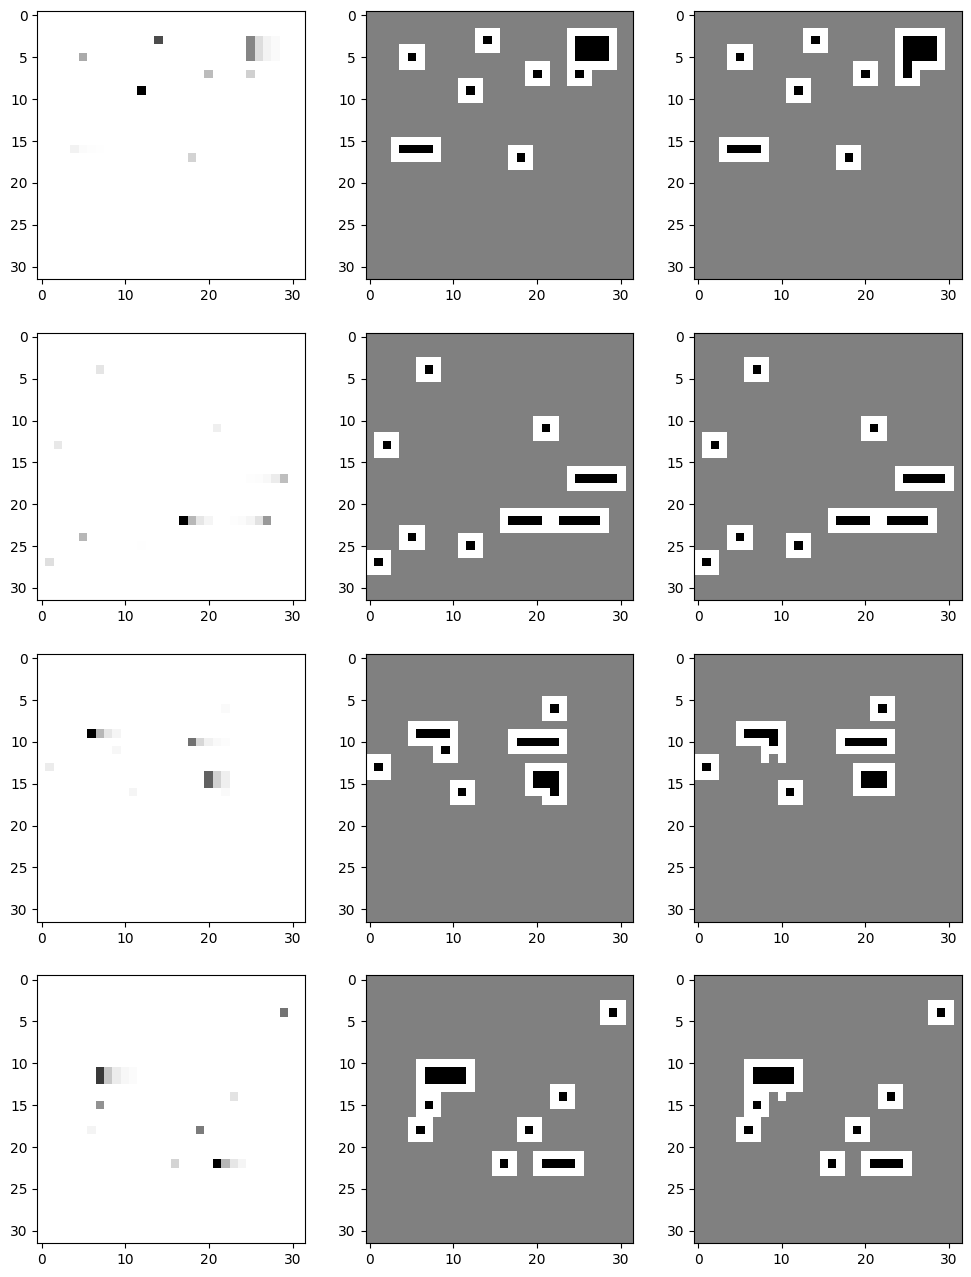

In [28]:
num_example_to_display = 4

fig, axs = plt.subplots(nrows=num_example_to_display, ncols=3, figsize=(12,4*num_example_to_display))
  
for i in range(num_example_to_display):
  axs[i][0].imshow(val_img[i])
  axs[i][1].imshow(np.squeeze(val_mask[i],-1), cmap='gray');
  axs[i][2].imshow(np.squeeze(pred_mask[i],-1), cmap='gray')

### T2: Instance Detection

In [29]:
import cv2

In [30]:
val_mask = np.array(val_mask)

val_mask[np.where(val_mask == 2)] = 1
pred_mask[np.where(pred_mask == 2)] = 1

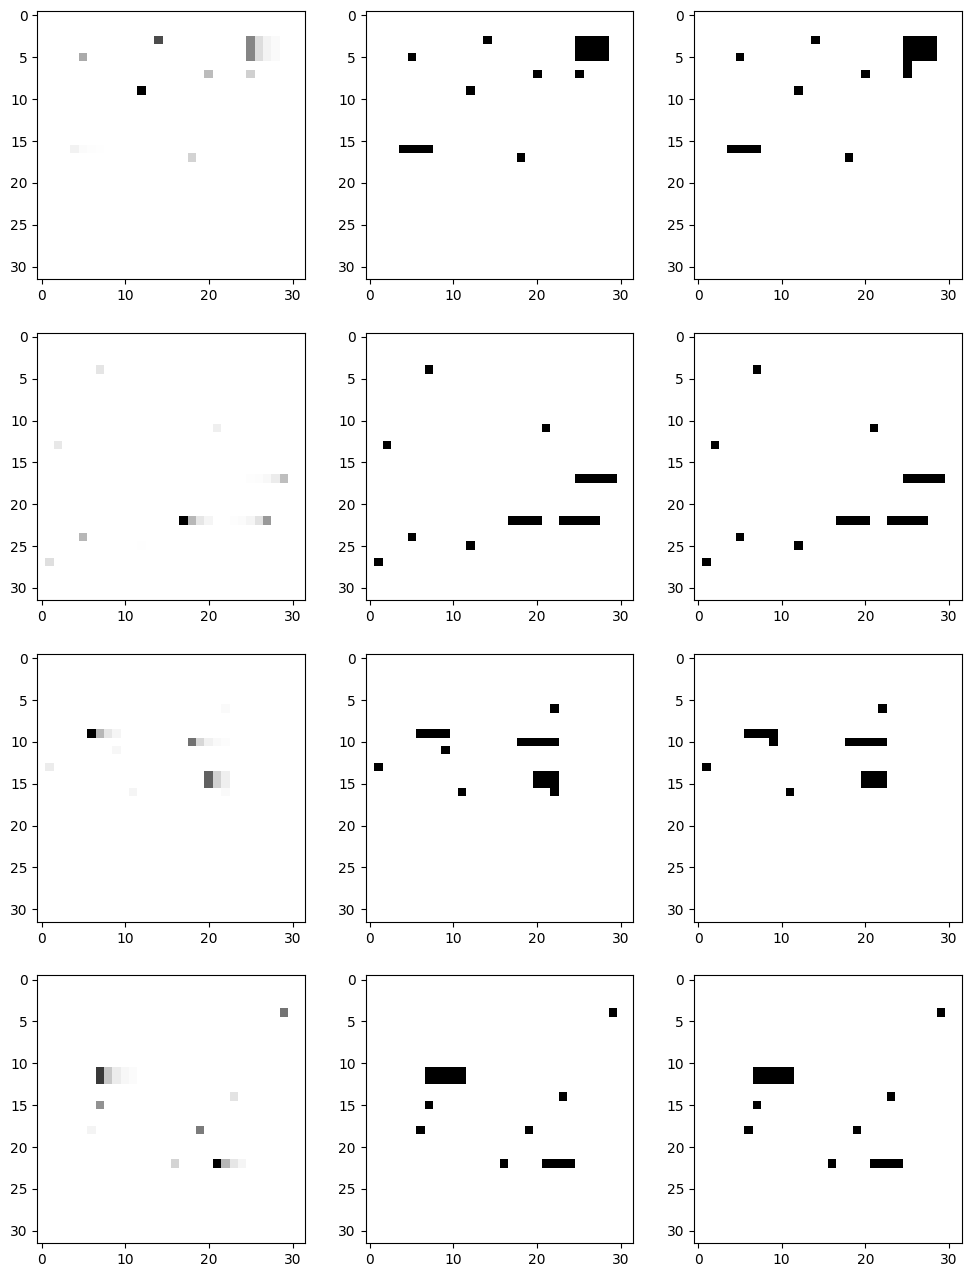

In [31]:
num_example_to_display = 4

fig, axs = plt.subplots(nrows=num_example_to_display, ncols=3, figsize=(12,4*num_example_to_display))

for i in range(num_example_to_display):
  axs[i][0].imshow(val_img[i])
  axs[i][1].imshow(np.squeeze(val_mask[i],-1), cmap='gray')
  axs[i][2].imshow(np.squeeze(pred_mask[i],-1), cmap='gray')

In [32]:
def ccl_generator(pred, mc_truth):
    test_image = np.squeeze(pred).astype("uint8")
    thresh = cv2.threshold(test_image, 0, 255,
        cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

    output_pred = cv2.connectedComponentsWithStats(
        thresh, 4, cv2.CV_32S)
    (numLabels_pred, labels_pred, stats_pred, centroids) = output_pred

    test_image = np.squeeze(mc_truth).astype("uint8")
    thresh = cv2.threshold(test_image, 0, 255,
        cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

    output_mc = cv2.connectedComponentsWithStats(
        thresh, 4, cv2.CV_32S)
    (numLabels_mc, labels_mc, stats_mc, centroids) = output_mc

    return labels_pred, labels_mc

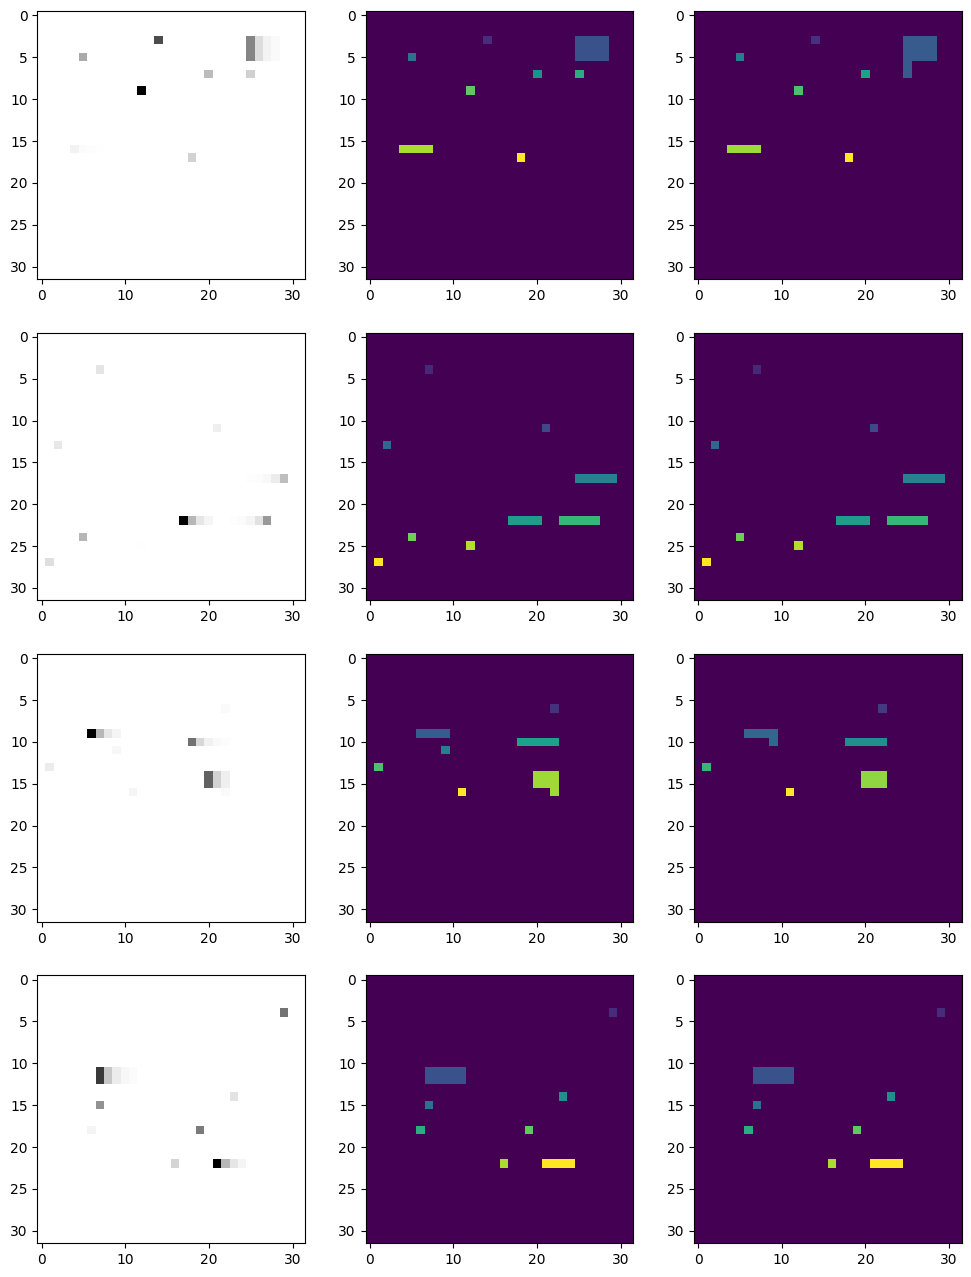

In [33]:
num_example_to_display = 4
fig, axs = plt.subplots(nrows=num_example_to_display, ncols=3, figsize=(12,4*num_example_to_display))
  
for i in range(num_example_to_display):
  lpred, lmc = ccl_generator(pred_mask[i], val_mask[i])
  axs[i][0].imshow(val_img[i])
  axs[i][1].imshow(lmc)
  axs[i][2].imshow(lpred)

### Testing

#### Helper Code

In [39]:
from collections import Counter

def eta_phi_res(ROI_mc, ROI_algo):
    eta_mc = max(ROI_mc[0]) - min(ROI_mc[0])
    phi_mc = max(ROI_mc[1]) - min(ROI_mc[1])

    eta_algo = max(ROI_algo[0]) - min(ROI_algo[0])
    phi_algo = max(ROI_algo[1]) - min(ROI_algo[1])

    return abs(eta_mc - eta_algo), abs(phi_mc - phi_algo)

In [40]:
def mc_label_convert(segmented_image, mc_truth):
    all_labels = np.unique(mc_truth)
    hm = {}
    for curr_label in all_labels:
        selected_ROI = segmented_image[np.where(mc_truth == curr_label)]
        hm[curr_label] = np.unique(selected_ROI)
    
    bkg = []
    for lt in hm.values():
        bkg.extend(lt)

    bkg_label = Counter(bkg).most_common(1)[-1][0]

    #setting background label
    segmented_image[np.where(segmented_image == bkg_label)] = 0.0
    hm.pop(0.0)
    
    for label in list(hm.keys())[::-1]:
        marked_pixels = []
        for pxm in hm[label]:
            if pxm == bkg_label:
                continue
                
            marked_pixels.append(np.where(segmented_image==pxm))
            
        for mp in marked_pixels:
            segmented_image[mp] = label

    return segmented_image

In [41]:
def test(predicted, mc_truth, energy_snap):
    thresh = 3
    y_pred = []
    energy_dist = []
    for label in np.unique(mc_truth):
        if label == 0.0:
            continue

        matched, rel_energy = False, -1
        ROI_mc = np.where(mc_truth==label)
        ROI_algo = np.where(predicted==label)

        E_mc = np.sum(energy_snap[ROI_mc])
        E_algo = np.sum(energy_snap[ROI_algo])

        if len(ROI_algo[0]) == 0:
            matched = (False, "False Negative")
            rel_energy = 1

        elif len(ROI_mc[0]) == 0 and len(ROI_algo[0]) !=0:
            matched = (False, "False Positive")
            rel_energy = 1

        else:
            eta_res, phi_res = eta_phi_res(ROI_mc, ROI_algo)

            if eta_res < thresh and phi_res < thresh:
                matched = True
                rel_energy = abs(E_algo - E_mc)/E_mc
            else:
                matched = (False, "Very Low Overlap")
                rel_energy = 1

        # collecting testing data
        y_pred.append(matched)
        if rel_energy >= 0: energy_dist.append(rel_energy)
    
    return y_pred, energy_dist

#### Main run

In [42]:
val_img, val_mask, pred_mask = [], [], []
for _ in range(30):
    val_img_i, val_mask_i = next(iter(maintestloader))
    pred_mask_i = model.predict(val_img_i)
    pred_mask_i = np.argmax(pred_mask_i, axis=-1)
    pred_mask_i = np.expand_dims(pred_mask_i, axis=-1)

    val_img.extend(val_img_i)
    val_mask.extend(val_mask_i)
    pred_mask.extend(pred_mask_i)

1/1 [==============================] - 0s 30ms/step


In [43]:
val_img = np.array(val_img)
val_mask = np.array(val_mask)
pred_mask = np.array(pred_mask)

In [44]:
all_matched, all_rel_energy, sn = [], [], 0
for i in range(len(val_img)):
    CLUSTER_TAGS = [-1]
    energy_snap = np.squeeze(val_img[i])
    lpred, lmc = ccl_generator(pred_mask[i], val_mask[i])
    try:
        predicted = mc_label_convert(lpred, lmc)
        matched, rel_energy = test(predicted, lmc, energy_snap)

        # matched
        all_matched.extend(matched)
        all_rel_energy.extend(rel_energy)

        sn += 1
    except:
        print("Error in ", i)
        pass

Text(0.5, 0, 'normalized energy difference')

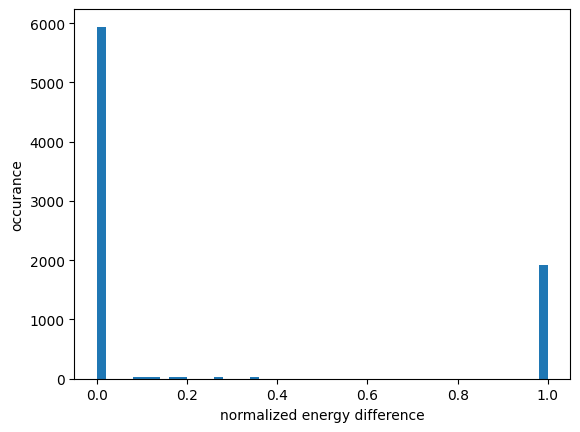

In [45]:
sub_rel = [i for i in all_rel_energy if i<=1]
plt.hist(sub_rel, bins=50)  # density=False would make counts
plt.ylabel('occurance')
plt.xlabel('normalized energy difference')

In [46]:
matches = len([x for x in all_matched if x==True])
print("Correct Matches: ", matches)
print("Incorrect Matched: ", len(all_matched) - matches)

Correct Matches:  6180
Incorrect Matched:  1920


In [47]:
unmatched = [x[1] for x in all_matched if type(x)==tuple]

In [48]:
threshold_mismatch = len([x for x in unmatched if x=='Very Low Overlap'])
print("Threshold Mismatch: ", threshold_mismatch)

fneg = len([x for x in unmatched if x=='False Negative'])
print("False Negative: ", fneg)

fposi = len([x for x in unmatched if x=='False Positive'])
print("False Positive: ", fposi)

Threshold Mismatch:  360
False Negative:  1560
False Positive:  0
